In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import astropy.units as u
import astropy.constants as const
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
# Equation of Kepler
def func(ecc, e, m):
    return ecc -e*np.sin(ecc)-m

In [3]:
# Orbital model
def model(t, t0, p, a, e, argp, incl, node):
    # Compute mean anomaly (radians)
    m = np.mod(2.0*np.pi*(t-t0)/p, 2.0*np.pi)

    # Keep between -pi and pi
    m[m>np.pi] -= 2.0*np.pi

    # Compute eccentric anomaly
    ecc = np.array([optimize.bisect(func, 0.0, np.pi, args=(e, np.abs(mm))) for mm in m])*np.sign(m)

    # Compute true anomaly
    nu = 2.0*np.arctan(np.sqrt((1.0+e)/(1.0-e))*np.tan(0.5*ecc))*u.rad

    # Radius
    r = a*(1.0-e*e)/(1.0+e*np.cos(nu))
    
    # Radial velocity
    vz = (2.0*np.pi/p)*a*np.sin(incl)*(np.cos(argp+nu)+e*np.cos(argp))/np.sqrt(1.0-e*e)

    # Rho and theta
    rho = r*np.sqrt((np.sin(argp+nu)*np.cos(incl))**2+np.cos(argp+nu)**2)
    theta = np.arctan2(np.sin(argp+nu)*np.cos(incl), np.cos(argp+nu))+node

    # Position
    x = rho*np.cos(theta)
    y = rho*np.sin(theta)
    z = r*np.sin(argp+nu)*np.sin(incl)
    
    return x, y, z, vz

In [4]:
# Sirius parameters (Bond et al. 2017, ApJ 840, 70)
t0 = 1994.5715*u.yr
p = 50.1284*u.yr
e = 0.59142
incl = 136.336*u.deg
argp = 149.161*u.deg
node = 45.4*u.deg
m1 = 2.063*u.solMass
m2 = 1.018*u.solMass

In [5]:
# Compute semi-major axis
a = (((p/(2.0*np.pi))**2*const.G*(m1+m2))**(1.0/3.0)).decompose()
a1 = a*m2/(m1+m2)
a2 = a*m1/(m1+m2)

In [6]:
# Compute time axis
tm = np.linspace(t0, t0+p, 1000)
phase = (tm-t0)/p

In [7]:
# Compute orbits
x1, y1, z1, vz1 = model(tm, t0, p, a1, e, argp, incl, node)
x2, y2, z2, vz2 = model(tm, t0, p, a2, e, argp, -incl, node+180.0*u.deg)
x, y, z, vz = model(tm, t0, p, -a, e, argp, incl, node)

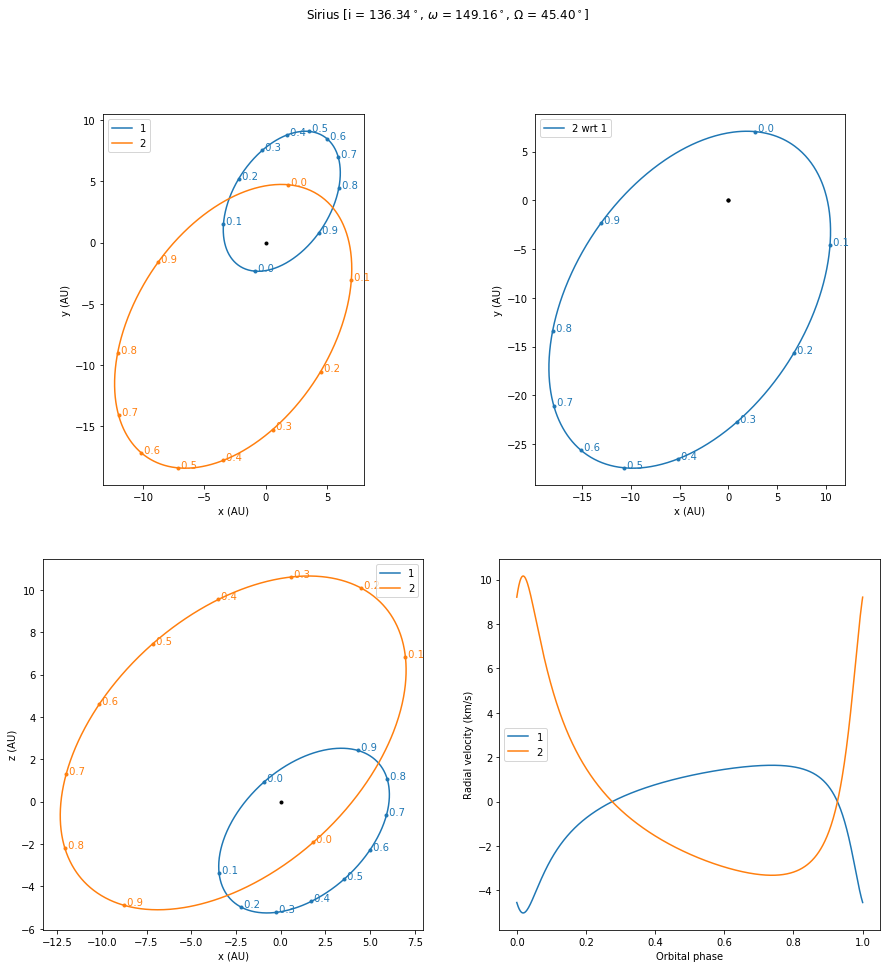

In [8]:
# Plot orbits
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221, aspect=1.0)
ax2 = fig.add_subplot(222, aspect=1.0)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.plot(0.0, 0.0, "k.")
ax1.plot(x1.to(u.au), y1.to(u.au), label="1", color="C0")
ax1.plot(x1[::100].to(u.au), y1[::100].to(u.au), marker=".", color="C0", linewidth=0)
for i in range(0, 1000, 100):
    ax1.annotate(" %.1f"%(phase[i]), (x1[i].to(u.au).value, y1[i].to(u.au).value), color="C0")
ax1.plot(x2.to(u.au), y2.to(u.au), label="2", color="C1")
ax1.plot(x2[::100].to(u.au), y2[::100].to(u.au), marker=".", color="C1", linewidth=0)
for i in range(0, 1000, 100):
    ax1.annotate(" %.1f"%(phase[i]), (x2[i].to(u.au).value, y2[i].to(u.au).value), color="C1")
ax1.legend()
ax1.set_xlabel("x (AU)")
ax1.set_ylabel("y (AU)")
ax2.plot(0.0, 0.0, "k.")
ax2.plot(0.0, 0.0, "k.")
ax2.plot(x.to(u.au), y.to(u.au), label="2 wrt 1", color="C0")
ax2.plot(x[::100].to(u.au), y[::100].to(u.au), marker=".", color="C0", linewidth=0)
for i in range(0, 1000, 100):
    ax2.annotate(" %.1f"%(phase[i]), (x[i].to(u.au).value, y[i].to(u.au).value), color="C0")
ax2.legend()
ax2.set_xlabel("x (AU)")
ax2.set_ylabel("y (AU)")
ax3.plot(0.0, 0.0, "k.")
ax3.plot(x1.to(u.au), z1.to(u.au), label="1", color="C0")
ax3.plot(x1[::100].to(u.au), z1[::100].to(u.au), marker=".", color="C0", linewidth=0)
for i in range(0, 1000, 100):
    ax3.annotate(" %.1f"%(phase[i]), (x1[i].to(u.au).value, z1[i].to(u.au).value), color="C0")
ax3.plot(x2.to(u.au), z2.to(u.au), label="2", color="C1")
ax3.plot(x2[::100].to(u.au), z2[::100].to(u.au), marker=".", color="C1", linewidth=0)
for i in range(0, 1000, 100):
    ax3.annotate(" %.1f"%(phase[i]), (x2[i].to(u.au).value, z2[i].to(u.au).value), color="C1")
ax3.legend()
ax3.set_xlabel("x (AU)")
ax3.set_ylabel("z (AU)")
ax4.plot(phase, vz1.to(u.km/u.s), label="1")
ax4.plot(phase, vz2.to(u.km/u.s), label="2")
ax4.legend()
ax4.set_xlabel("Orbital phase")
ax4.set_ylabel("Radial velocity (km/s)")
plt.suptitle(r"Sirius [i = {:.2f}$^\circ$, $\omega$ = {:.2f}$^\circ$, $\Omega$ = {:.2f}$^\circ$]".format(incl.to(u.deg).value, argp.to(u.deg).value, node.to(u.deg).value))
plt.show()

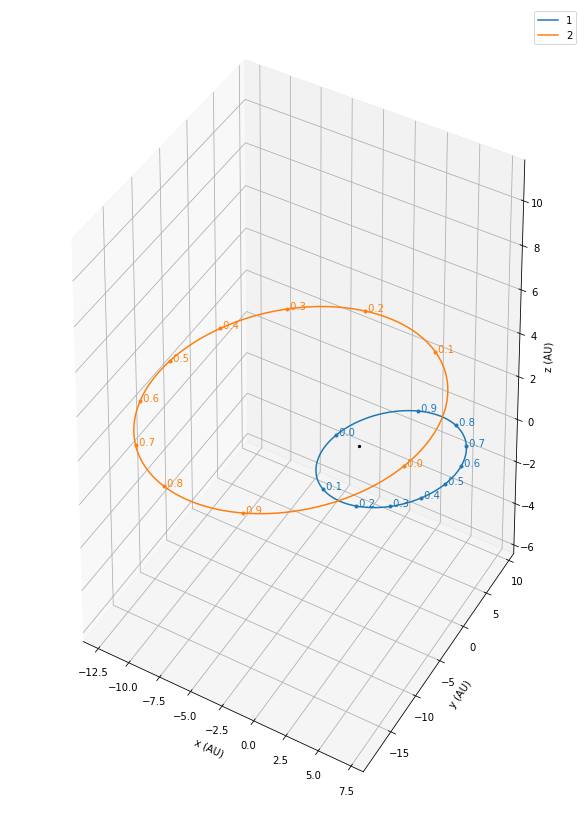

In [9]:
# Plot binary orbits in 3D
fig = plt.figure(figsize=(15, 15))
ax = fig.gca(projection="3d")
ax.set_aspect("equal")
ax.scatter(0.0, 0.0, 0.0, marker=".", color="k")
ax.plot(x1.to(u.au), y1.to(u.au), z1.to(u.au), label="1")
ax.plot(x1[::100].to(u.au), y1[::100].to(u.au), z1[::100].to(u.au), marker=".", color="C0", linewidth=0)
for i in range(0, 1000, 100):
    ax.text(x1[i].to(u.au).value, y1[i].to(u.au).value, z1[i].to(u.au).value, " {:.1f}".format(phase[i]), color="C0")
ax.plot(x2.to(u.au), y2.to(u.au), z2.to(u.au), label="2")
ax.plot(x2[::100].to(u.au), y2[::100].to(u.au), z2[::100].to(u.au), marker=".", color="C1", linewidth=0)
for i in range(0, 1000, 100):
    ax.text(x2[i].to(u.au).value, y2[i].to(u.au).value, z2[i].to(u.au).value, " {:.1f}".format(phase[i]), color="C1")
ax.legend()
ax.set_xlabel("x (AU)")
ax.set_ylabel("y (AU)")
ax.set_zlabel("z (AU)")
plt.show()